In [15]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS

from collections import Counter
import pprint
import re
import string

import spacy
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import pyLDAvis.gensim_models
import gensim
from gensim import corpora
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
#!python3 -m spacy download en_core_web_sm

[nltk_data] Downloading package punkt to /Users/mintee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
df = pd.read_csv('../../data/raw/reviews.csv')
df.head()

,Sentiment,Time,Text
0,positive,18/6/21,This is a very healthy dog food. Good for thei...
1,positive,7/7/21,I've been very pleased with the Natural Balanc...
2,positive,18/6/21,"Before I was educated about feline nutrition, ..."
3,positive,7/7/21,"My holistic vet recommended this, along with a..."
4,positive,1/7/21,I bought this coffee because its much cheaper ...


## Sentiment distribution

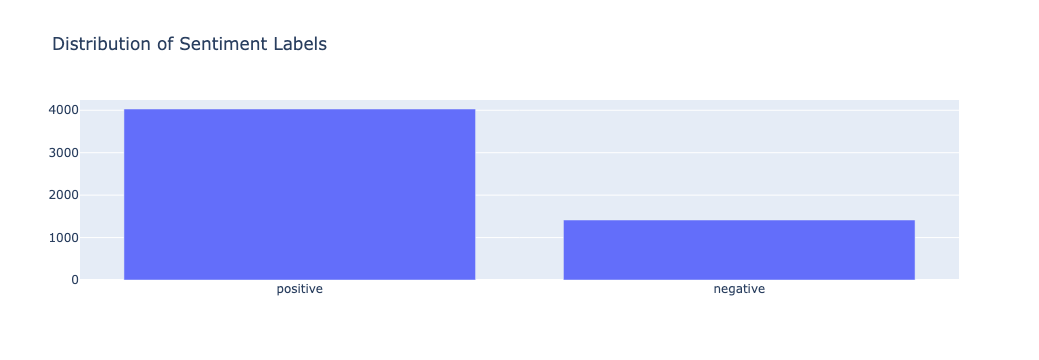

In [17]:
# Count the number of reviews for each sentiment
sentiment_counts = df['Sentiment'].value_counts()
data = go.Bar(x=sentiment_counts.index, y=sentiment_counts.values)
layout = go.Layout(title='Distribution of Sentiment Labels')
fig = go.Figure(data=data, layout=layout)
fig.show()

As shown, the data set is slightly imbalanced with 4030 positve sentiments and 1414 negative sentiments

## Recency of the data

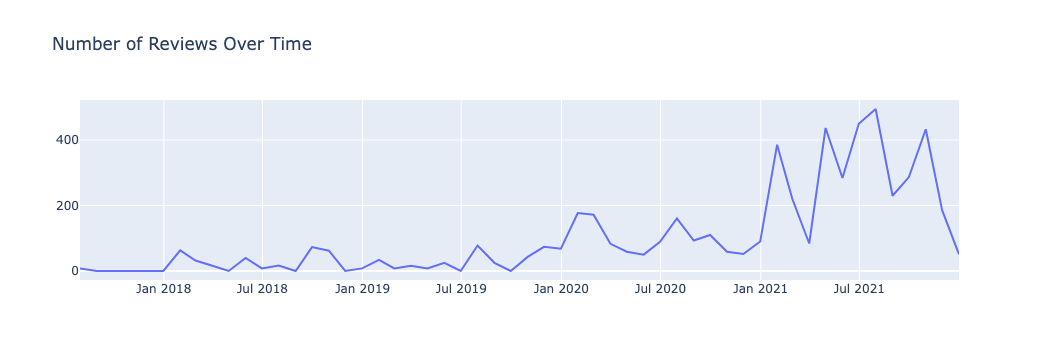

In [18]:
df['Time'] = pd.to_datetime(df['Time'])
reviews_by_date = df.groupby(pd.Grouper(key='Time', freq='M')).size()

data = go.Scatter(x=reviews_by_date.index, y=reviews_by_date.values, mode='lines')
layout = go.Layout(title='Number of Reviews Over Time')
fig = go.Figure(data=data, layout=layout)
fig.show()

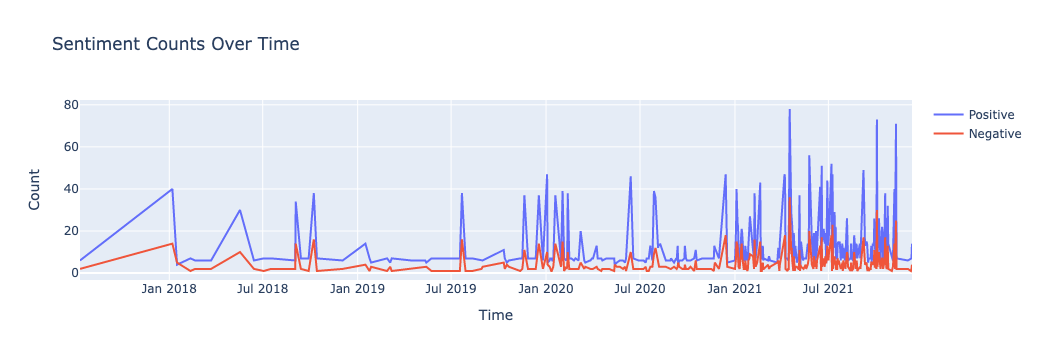

In [19]:
sentiment_counts = df.groupby(['Time', 'Sentiment']).size().reset_index(name='count')

fig = go.Figure()
fig.add_trace(go.Scatter(x=sentiment_counts[sentiment_counts['Sentiment'] == 'positive']['Time'], 
                         y=sentiment_counts[sentiment_counts['Sentiment'] == 'positive']['count'], 
                         mode='lines', name='Positive'))

fig.add_trace(go.Scatter(x=sentiment_counts[sentiment_counts['Sentiment'] == 'negative']['Time'], 
                         y=sentiment_counts[sentiment_counts['Sentiment'] == 'negative']['count'], 
                         mode='lines', name='Negative'))
fig.update_layout(title='Sentiment Counts Over Time', xaxis_title='Time', yaxis_title='Count')
fig.show()

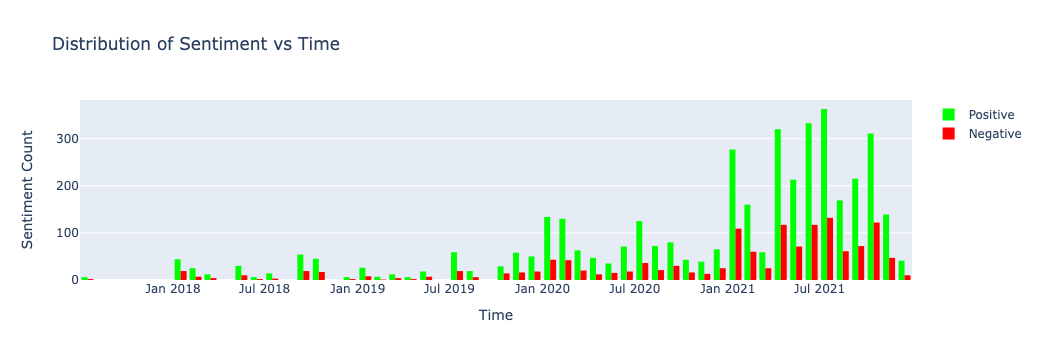

In [20]:
positive_trace = go.Histogram(x=df[df['Sentiment'] == 'positive']['Time'], 
                              name='Positive', 
                              marker_color='#00FF00')
negative_trace = go.Histogram(x=df[df['Sentiment'] == 'negative']['Time'], 
                              name='Negative', 
                              marker_color='#FF0000')
fig = go.Figure()
fig.add_trace(positive_trace)
fig.add_trace(negative_trace)
fig.update_layout(title='Distribution of Sentiment vs Time', xaxis_title='Time', yaxis_title='Sentiment Count')
fig.show()

## Exploring reviews columns

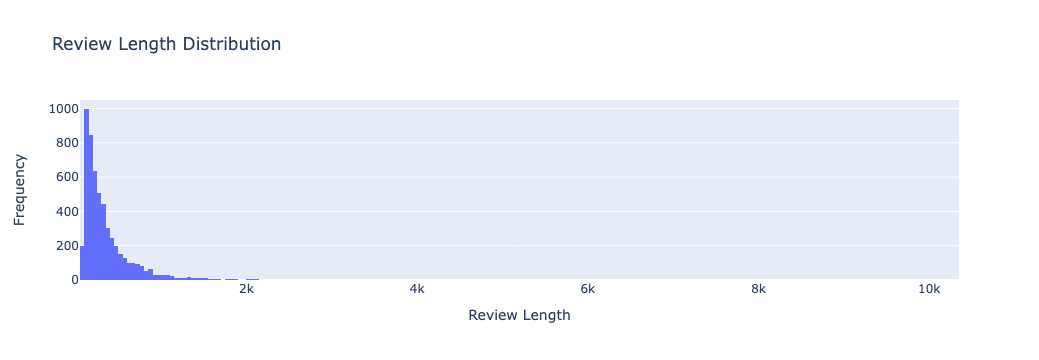

In [21]:
df['review_length'] = df['Text'].apply(len)
fig = go.Figure(data=[go.Histogram(x=df['review_length'])])
fig.update_layout(
    title="Review Length Distribution",
    xaxis_title="Review Length",
    yaxis_title="Frequency"
)
fig.show()

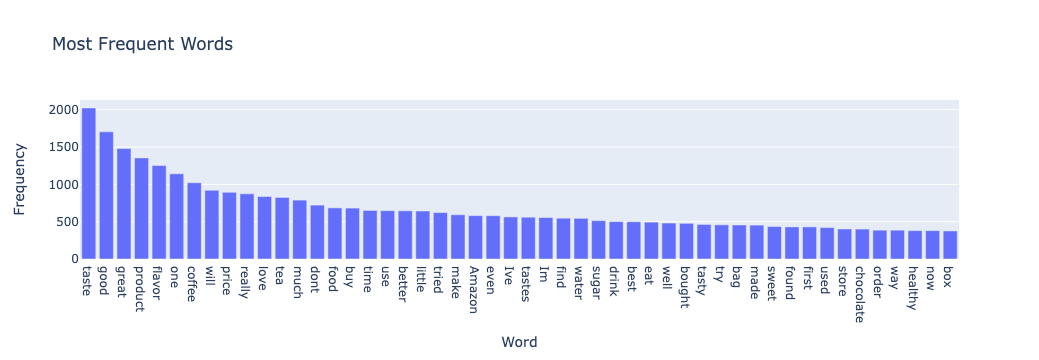

In [22]:
reviews_text = " ".join(df['Text'])
# remove <br> tags from the text
reviews_text = re.sub(r'<br\s?\/?>', ' ', reviews_text)
# remove punctuation from the text
reviews_text = reviews_text.translate(str.maketrans('', '', string.punctuation))
# remove stop words from the text
sw = set(STOPWORDS)
words = [w for w in reviews_text.split() if w.lower() not in sw]

word_counts = Counter(words).most_common(50)
fig = go.Figure([go.Bar(x=[w[0] for w in word_counts], y=[w[1] for w in word_counts])])
fig.update_layout(title="Most Frequent Words", xaxis_title="Word", yaxis_title="Frequency")
fig.show()

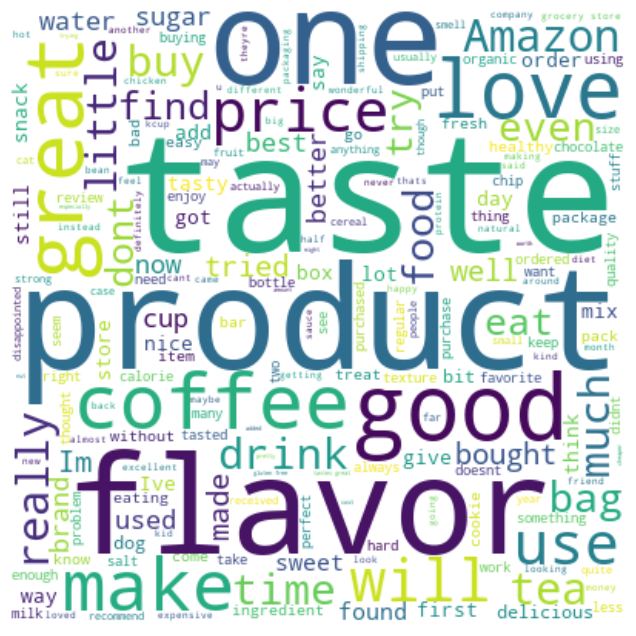

In [23]:
%%capture --no-display
# create a wordcloud of the most frequent words
wordcloud = WordCloud(width=400, height=400, background_color="white", stopwords=sw).generate(reviews_text)
fig = plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

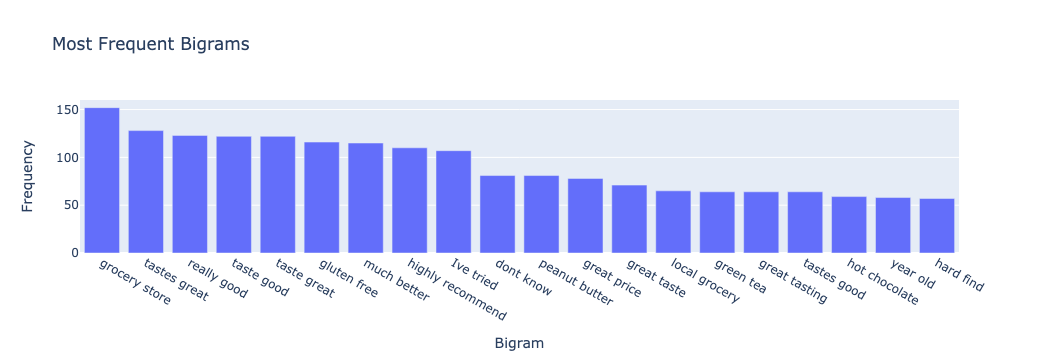

In [24]:
# get the most frequent bigrams and their counts, filtering out those that contain stop words
bigrams = [b for b in zip(words[:-1], words[1:]) if b[0].lower() not in sw and b[1].lower() not in sw]
bigram_counts = Counter(bigrams).most_common(20)
fig = go.Figure([go.Bar(x=[" ".join(b) for b in [w[0] for w in bigram_counts]], y=[w[1] for w in bigram_counts])])
fig.update_layout(title="Most Frequent Bigrams", xaxis_title="Bigram", yaxis_title="Frequency")
fig.show()

Conclusion:
- Amazon dataset 
- Mainly f&b/grocery products reviewing taste and quality of a product
- Coffee, tea, peanut butter, hot chocolate are some of the products
- More Positive sentiments than negative sentiments (products doing fairly well)
- Date range of data is from 2017-2021 but the number of reviews really exploded in 2020-2021 (Relation with Covid and online shopping?)

## Identify product genre

### Clean data

In [25]:
# define a function to clean the text data
def clean_text(text):
    # remove <br> tags
    text = re.sub(r'<br\s?\/?>', ' ', text)
    # expand contractions
    expanded_text = []
    for word in text.split():
      expanded_text.append(contractions.fix(word))  
    expanded_text = ' '.join(expanded_text)
    # make all words lower case
    expanded_text = expanded_text.lower()
    # remove punctuation
    expanded_text = expanded_text.translate(str.maketrans('', '', string.punctuation))
    # remove stopwords
    stopwords_list = stopwords.words('english')
    stopwords_list.extend(['from', 'subject', 're', 'edu', 'use'])
    words_clean = [word for word in expanded_text.split() if word.lower() not in stopwords_list]
    return " ".join(words_clean)

In [26]:
df['clean_reviews'] = df['Text'].apply(clean_text)
df['clean_review_length'] = df['clean_reviews'].apply(len)
df.head()

,Sentiment,Time,Text,review_length,clean_reviews,clean_review_length
0,positive,2021-06-18,This is a very healthy dog food. Good for thei...,137,healthy dog food good digestion also good smal...,94
1,positive,2021-07-07,I've been very pleased with the Natural Balanc...,350,pleased natural balance dog food dogs issues d...,218
2,positive,2021-06-18,"Before I was educated about feline nutrition, ...",733,educated feline nutrition allowed cats become ...,508
3,positive,2021-07-07,"My holistic vet recommended this, along with a...",493,holistic vet recommended along brands tried ca...,276
4,positive,2021-01-07,I bought this coffee because its much cheaper ...,413,bought coffee much cheaper ganocafe organic re...,218


In [27]:
#df.to_csv('../../data/clean/cleaned_reviews.csv')

Cleaned data to be used for Sentiment Analysis and Topic Modelling